# Preprocessing

In [ ]:
f = open('fips_county_state.txt', 'r')

fips = []
name = []
d = {}
for line in f:
    # Split on any whitespace (including tab characters)
    row = line.split()
    fips.append(row[0])
    s = ""
    for i in range(1, len(row)):
      if i != len(row)-1:
        s = s + row[i] + "_"
      else:
        s = s +"County_" + row[i]
    name.append(s)
    d.update({s:str(row[0])})

f.close()

#print(fips,name)

In [ ]:
 f = open('counties_list.txt', 'r')

order = {}
order2 = {}
i = 1
for line in f:
  row = line.split()
  print(row[0])
  if row[0] in d:
   order.update({row[0]:i})
   order2.update({i:row[0]})

  i = i+1

f.close()

#order

Archive:  pa_County.zip
 extracting: pa_county/PaCounty2024_03.CPG  
  inflating: pa_county/PaCounty2024_03.dbf  
  inflating: pa_county/PaCounty2024_03.prj  
  inflating: pa_county/PaCounty2024_03.sbn  
  inflating: pa_county/PaCounty2024_03.sbx  
  inflating: pa_county/PaCounty2024_03.shp  
  inflating: pa_county/PaCounty2024_03.shp.xml  
  inflating: pa_county/PaCounty2024_03.shx  
  inflating: pa_county/PaCounty2024_03.xml  
  inflating: pa_county/County_Boundary_Data_Dictionary.pdf  


<Axes: >

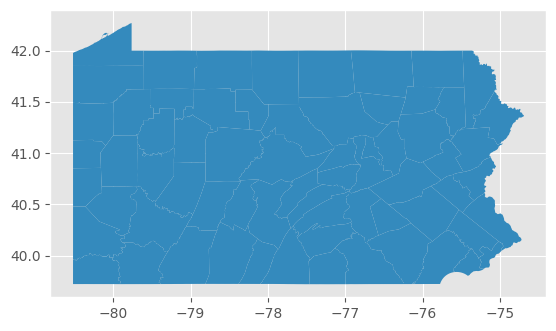

In [ ]:
import os

try:
  if not os.path.isdir('pa_county'):
    !unzip pa_County.zip -d pa_county
  pass
except:
  pass
#!pip install shapely==1.8

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Unclutter the display.
#import pandas as pd
#pd.set_option('max_columns', 6)
try:
  import geopandas as gpd
except:
  !pip install geopandas
  import geopandas as gpd

#fp = "CA_Counties/CA_Counties_TIGER2016.shp"
fp = "pa_county/PaCounty2024_03.shp"

#reading the file stored in variable fp
map_df = gpd.read_file(fp)
map_df = map_df.to_crs(epsg=4326)
map_df.plot()

In [ ]:
import pandas as pd
import numpy as np
import torch

df = pd.read_csv('data_oud_pa.csv')

df = df.dropna()

df.columns = map_df['COUNTY_NAM'].tolist()
df_average = [0]*len(map_df)
df_std = [0]*len(map_df)
for i in range(len(df.iloc[0])-2):
  ls = []
  for j in range(len(df)-1):
    #print(i,j,df.iloc[j][i])
    ls.append(int(df.iloc[j][i]))

  df_average[i] = sum(ls) / len(ls)
  df_std[i] = np.std(ls)

In [ ]:
import numpy as np
arr = [int(df[map_df['COUNTY_NAM'].loc[i]].loc[i]) for i in range(len(map_df))]
merged = map_df.join(pd.DataFrame(arr,columns=['ODD']))
#merged.head()



# GP part

In [ ]:
import torch
import numpy as np
try:
  from botorch.models import SingleTaskGP, Ex, MultiTaskGP
except:
  !pip install botorch
  from botorch.models import SingleTaskGP, MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood, MarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize

from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.acquisition.analytic import PosteriorStandardDeviation

from botorch.optim import optimize_acqf, optimize_acqf_mixed, optimize_acqf_discrete_local_search
from botorch.sampling.normal import SobolQMCNormalSampler

from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=1)

batch_size = 2

#ls = np.zeros((len(map_df),2))
ls = np.array([map_df['geometry'].loc[0].centroid.x, map_df['geometry'].loc[0].centroid.y]).reshape(1,-1)
y = np.array(int(df[map_df['COUNTY_NAM'].iloc[i]].iloc[0])).reshape(-1,1)

for i in range(1,len(map_df)):
  #print(i)
  for j in range(batch_size):
    ls = np.append(ls, np.array([map_df['geometry'].loc[i].centroid.x, map_df['geometry'].loc[i].centroid.y]).reshape(1,-1), axis=0)
    y = np.append(y, np.array(int(df[map_df['COUNTY_NAM'].iloc[i]].iloc[j+1])).reshape(1,-1), axis=0)

train_X = torch.Tensor(np.array(ls))

train_Y = 1 - (train_X - 0.5).norm(dim=-1, keepdim=True)
train_Y += 0.1 * torch.rand_like(train_Y)
train_Y = torch.Tensor(y)

gp = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
#fit_gpytorch_mll(mll)

In [ ]:
import numpy as np
import random
from shapely.geometry import Point
#from shapely.geometry import MultiPoint
from shapely.geometry.polygon import Polygon

from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=10)


l_bounds = [-79.21049943375089, 40.81555532075]
u_bounds = [-78.70396386132802, 41.355336251154925]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

x=map_df['geometry'].loc[0]
bounds = map_df.geometry.apply(lambda x: x.bounds).tolist()

point = Point(-80.07562,40.39311111)
print("print",x,bounds[0],bounds[0][0]/175000,x.contains(point))

arr = df.to_numpy()
arr_loc = np.zeros((len(map_df)))
print(len(arr))
for i in range(len(map_df.index)):
    x=map_df['geometry'].loc[i]
    point = Point(candidate[0][0],candidate[0][1])
    if x.contains(point) or x.touches(point):
        print("yes",map_df['COUNTY_NAM'].loc[i],i)

def get_index(arr,df):
  for i in range(len(df.index)):
    x=map_df['geometry'].loc[i]
    point = Point(arr[0][0],arr[0][1])

    if x.contains(point): #or x.touches(point):
        return i


def adjust_loc(arr, map_df):
  e = 0.35
  f1 = f2 = f3 = f4 = 0
  if arr[0][0] <= -80.48:
    f1 = 1
  if arr[0][0] >= -75.28:
    f2 = 1
  if arr[0][1] <= 39.72:
    f3 = 1
  if arr[0][1] >= 42.25:
    f4 = 1

  if f1 == 1:
    arr[0][0] = arr[0][0] + np.abs(-1*arr[0][0]-80.48)  + e
  if f2 == 1:
    arr[0][0] = arr[0][0] - np.abs(-1*arr[0][0]-75.28)  - e
  if f3 == 1:
    arr[0][1] = arr[0][1] - np.abs(arr[0][1]-39.68)  + e
  if f4 == 1:
    arr[0][1] = arr[0][1] - np.abs(arr[0][1]-41.8)  - e

  return arr

def random_points_in_polygon(number, polygon):
    points = []
    ls = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        x1 = random.uniform(min_x, max_x)
        y1 = random.uniform(min_y, max_y)
        point = Point(x1, y1)
        ls_new = [x1,y1]
        if polygon.contains(point):
            points.append(point)
            ls.append(ls_new)
            i += 1
    return ls

def random_points_in_polygon_2(number, polygon):
  sampler = qmc.LatinHypercube(d=2)
  sample = sampler.random(n=10)
  points = []
  ls = []
  min_x, min_y, max_x, max_y = polygon.bounds
  i= 0
  l_bounds = [min_x, min_y]
  u_bounds = [max_x, max_y]

  while i < number:
        sample = sampler.random(n=number)
        ls_pnt = qmc.scale(sample, l_bounds, u_bounds)
        x1 = ls_pnt[0][0]
        y1 = ls_pnt[0][1]
        point = Point(x1, y1)
        ls_new = [x1,y1]
        if polygon.contains(point):
            points.append(point)
            ls.append(ls_new)
            i += 1
  return ls

from functools import reduce

def get_random(arr):
  sampler = qmc.LatinHypercube(d=2)
  sample = sampler.random(n=10)
  points = []
  ls = []
  min_x, min_y, max_x, max_y = arr
  i= 0
  l_bounds = [min_x, min_y]
  u_bounds = [max_x, max_y]

  while 1:
    sample = sampler.random(n=1)
    ls_pnt = qmc.scale(sample, l_bounds, u_bounds)
    x1 = ls_pnt[0][0]
    y1 = ls_pnt[0][1]
    ls_new = [x1,y1]
    point = Point(x1, y1)
    ls = map_df.contains(point).to_list()
    val =reduce(lambda x, y: x+y, ls)
    if val:
        break
  return ls_new

#random_points_in_polygon_2(1,map_df['geometry'].iloc[32])

In [ ]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.base import MCSampler
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from botorch.acquisition.objective import PosteriorTransform

from torch import Tensor

from botorch.acquisition import AnalyticAcquisitionFunction

class Entropy(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
    ) -> None:
        r"""Single-outcome Posterior Mean.

        Args:
            model: A fitted single-outcome GP model (must be in batch mode if
                candidate sets X will be)
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem. Note
                that if `maximize=False`, the posterior standard deviation is negated.
                As a consequence,
                `optimize_acqf(PosteriorStandardDeviation(gp, maximize=False))`
                actually returns -1 * minimum of the posterior standard deviation.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate the posterior standard deviation on the candidate set X.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Posterior Mean values at the
            given design points `X`.
        """
        _, std = self._mean_and_sigma(X)
        #1/2 log (2\pi\sigma^2)+0.5
        entropy = 0.5*torch.log(2*math.pi*std**2) + 0.001
        return entropy if self.maximize else -entropy

# ----------------Signal to noise ratio AF ------------------------------
class SignalToNoiseRatio(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
    ) -> None:
        r"""Single-outcome Posterior Mean.

        Args:
            model: A fitted single-outcome GP model (must be in batch mode if
                candidate sets X will be)
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem. Note
                that if `maximize=False`, the posterior standard deviation is negated.
                As a consequence,
                `optimize_acqf(PosteriorStandardDeviation(gp, maximize=False))`
                actually returns -1 * minimum of the posterior standard deviation.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate the posterior standard deviation on the candidate set X.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Posterior Mean values at the
            given design points `X`.
        """
        mu, std = self._mean_and_sigma(X)
        ratio = (2*1.96*std)/mu + 0.0001
        return ratio if self.maximize else -1*ratio
# ----------------Signal to noise ratio+Entropy AF ------------------------------
class EntropySNR(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
    ) -> None:
        r"""Single-outcome Posterior Mean.

        Args:
            model: A fitted single-outcome GP model (must be in batch mode if
                candidate sets X will be)
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem. Note
                that if `maximize=False`, the posterior standard deviation is negated.
                As a consequence,
                `optimize_acqf(PosteriorStandardDeviation(gp, maximize=False))`
                actually returns -1 * minimum of the posterior standard deviation.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate the posterior standard deviation on the candidate set X.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Posterior Mean values at the
            given design points `X`.
        """
        mu, std = self._mean_and_sigma(X)
        #ratio = 0.5*torch.log(2*math.pi*std**2) - mu/std + 0.5
        ratio = 2*1.96*std + 0.01
        return ratio if self.maximize else -ratio

In [ ]:
import gpytorch
import warnings
import datetime
import pytz
from torch.optim import SGD, Adam

start = datetime.datetime.utcnow().astimezone(pytz.timezone('US/Eastern'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

warnings.filterwarnings("ignore")
torch.set_warn_always(True)

SMOKE_TEST = False

N_TRIALS = 1 if not SMOKE_TEST else 2
N_BATCH = 4000 if not SMOKE_TEST else 2
#was 512
MC_SAMPLES = 512 if not SMOKE_TEST else 32

counter = 0
x = np.array([-80.48,39.68])
y = np.array([-75.28,41.8])
bounds = torch.stack([torch.Tensor(x), torch.Tensor(y)])
count1 = [0 for i in range(len(map_df))]
count2 = [0 for i in range(len(map_df))]
count3 = [0 for i in range(len(map_df))]
count4 = [0 for i in range(len(map_df))]
count5 = [0 for i in range(len(map_df))]
allegheny_mse_ucb = []
allegheny_mse_ei = []
allegheny_mse_pstd = []
allegheny_mse_random = []
allegheny_mse_maxEntropy = []

jeff_flag = False
allegheny_flag = False
jeff_mse_ucb = []
jeff_mse_ei = []
jeff_mse_pstd = []
jeff_mse_maxEntropy = []

allegheny_std_ucb = []
allegheny_std_ei = []
allegheny_std_pstd = []
allegheny_std_random = []
allegheny_std_maxEntropy = []

jeff_std_ucb = []
jeff_std_ei = []
jeff_std_pstd = []
jeff_std_maxEntropy = []
allegheny_shape = map_df['geometry'].iloc[1]
jeff_shape = map_df['geometry'].iloc[32]
#was 3000
num_samples = 67

ls_jeff = ls_allegheny = np.zeros((num_samples,2))
for i in range((num_samples)):
  allegheny_loc = random_points_in_polygon(1,allegheny_shape)[0]
  jeff_loc = random_points_in_polygon(1,jeff_shape)[0]
  ls_jeff[i,0] = allegheny_loc[0]
  ls_jeff[i,1] = allegheny_loc[1]
  ls_allegheny[i,0] = jeff_loc[0]
  ls_allegheny[i,1] = jeff_loc[1]


train_X_ucb = train_X
train_X_ei = train_X
train_X_pstd = train_X
train_X_maxEntropy = train_X
train_Y_ucb = train_Y
train_Y_ei = train_Y
train_Y_pstd = train_Y
train_Y_maxEntropy = train_Y

gp_ei = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
gp_ucb = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
gp_pstd = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
gp_maxEntropy = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
PosteriorStandardDeviation(gp)

for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_ucb, best_random = [], [], []


    gp_ei = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
    gp_ucb = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
    gp_pstd = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
    gp_maxEntropy = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))

    iteration = 0
    while iteration < N_BATCH:
      iteration += 1

      lr_val = max(0.07, 0.2 - iteration*0.0001)
      lr_val = 0.16
      #print(lr_val)
      #was SGD, Adam
      with gpytorch.settings.cholesky_max_tries(100):
        for k in range(20):
          optimizer_ucb = Adam([{"params": gp_ucb.parameters()}], lr=lr_val/2)
          optimizer_ei = Adam([{"params": gp_ei.parameters()}], lr=lr_val)
          optimizer_pstd = Adam([{"params": gp_pstd.parameters()}], lr=lr_val)
          optimizer_maxEntropy = Adam([{"params": gp_maxEntropy.parameters()}], lr=lr_val)

          optimizer_ucb.zero_grad()
          optimizer_ei.zero_grad()
          optimizer_pstd.zero_grad()
          optimizer_maxEntropy.zero_grad()


          mll_ei = ExactMarginalLogLikelihood(gp_ei.likelihood, gp_ei)
          mll_ucb = ExactMarginalLogLikelihood(gp_ucb.likelihood, gp_ucb)
          mll_pstd = ExactMarginalLogLikelihood(gp_pstd.likelihood, gp_pstd)
          mll_maxEntropy = ExactMarginalLogLikelihood(gp_maxEntropy.likelihood, gp_maxEntropy)

          #mll_random = ExactMarginalLogLikelihood(gp_random.likelihood, gp_random)
          #mll_random = ExactMarginalLogLikelihood(gp.likelihood, gp)

          output1 = gp_ei(train_X_ei)
          output2 = gp_ucb(train_X_ucb)
          output3 = gp_pstd(train_X_pstd)
          #output4 = gp_random(train_X_random)
          output5 = gp_maxEntropy(train_X_maxEntropy)

          loss_ei = -mll_ei(output1, gp_ei.train_targets)
          loss_ucb = -mll_ucb(output2, gp_ucb.train_targets)
          loss_pstd = -mll_pstd(output3, gp_pstd.train_targets)
          loss_maxEntropy = -mll_maxEntropy(output5, gp_maxEntropy.train_targets)
          #loss_random = -mll_random(output4, gp_random.train_targets)

          loss_ei.backward()
          loss_ucb.backward()
          loss_pstd.backward()
          loss_maxEntropy.backward()
          #loss_random.backward()

          optimizer_ucb.step()
          optimizer_ei.step()
          optimizer_pstd.step()
          optimizer_maxEntropy.step()


        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_pstd)
        fit_gpytorch_mll(mll_maxEntropy)



      UCB = SignalToNoiseRatio(gp_ucb)

      ei = Entropy(model=gp_ei)

      pstd = EntropySNR(model=gp_pstd)

      maxEntropy = qMaxValueEntropy(model=gp_maxEntropy, candidate_set=torch.Tensor(ls), maximize=False)


      candidate_ucb, acq_value_ucb = optimize_acqf_discrete_local_search(
                         acq_function = UCB,
                         q=1,
                         discrete_choices = choice, #[{1: [[-77.1511,  41.5541]]}, {2: [[-75.5931,  40.6137]]} ],
                         num_restarts = 20,
                         raw_samples = MC_SAMPLES,
                        )

      candidate_ei, acq_value_ei = optimize_acqf_discrete_local_search(
                         acq_function = ei,
                         q=1,
                         discrete_choices = choice, #[{1: [[-77.1511,  41.5541]]}, {2: [[-75.5931,  40.6137]]} ],
                         num_restarts = 20,
                         raw_samples = MC_SAMPLES,
                         #options = {"batch_limit": 5, "maxiter": 200}
                        )

      candidate_pstd, acq_value_pstd = optimize_acqf_discrete_local_search(
                         acq_function = pstd,
                         q=1,
                         discrete_choices = choice, #[{1: [[-77.1511,  41.5541]]}, {2: [[-75.5931,  40.6137]]} ],
                         num_restarts = 20,
                         raw_samples = MC_SAMPLES,
                        )


      candidate_maxEntropy, acq_value_maxEntropy =  optimize_acqf(
        maxEntropy, bounds=bounds, q=1, num_restarts=30, raw_samples=MC_SAMPLES,)

      #print(candidate_ucb)
      idx = get_index(candidate_ucb,map_df)
      if not idx:
        print("Here in idx:", candidate_ucb)
        candidate_ucb2 = adjust_loc(candidate_ucb, map_df)
        print("Here in idx:", candidate_ucb2)
        candidate_ucb = candidate_ucb2
        idx = get_index(candidate_ucb,map_df)

        if not idx:
          iteration -= 1
          continue

      #print(idx)
      y_value_ucb = df[map_df['COUNTY_NAM'].loc[idx]].loc[count1[idx]]
      count1[idx] += 1

      idx2 = get_index(candidate_ei,map_df)
      if not idx2:
        print("Here in idx2:", candidate_ei)
        candidate_ei2 = adjust_loc(candidate_ei, map_df)
        print("Here in idx2:", candidate_ei2)
        candidate_ei = candidate_ei2
        idx2 = get_index(candidate_ei,map_df)

        if not idx2:
          iteration -= 1
          continue

      y_value_ei = df[map_df['COUNTY_NAM'].loc[idx2]].loc[count2[idx2]]
      count2[idx2] += 1


      idx3 = get_index(candidate_pstd,map_df)
      if not idx3:
        print("Here in idx3:", candidate_pstd)
        candidate_pstd2 = adjust_loc(candidate_pstd, map_df)
        print("Here in idx3:", candidate_pstd2)
        candidate_pstd = candidate_pstd2
        idx3 = get_index(candidate_pstd,map_df)

        if not idx3:
          iteration -= 1
          continue

      y_value_pstd = df[map_df['COUNTY_NAM'].loc[idx3]].loc[count3[idx3]]
      count3[idx3] += 1


      idx5 = get_index(candidate_maxEntropy,map_df)
      if not idx5:
        print("Here in idx5:", candidate_maxEntropy)
        candidate_maxEntropy2 = adjust_loc(candidate_maxEntropy, map_df)
        print("Here in idx5:", candidate_maxEntropy2)
        candidate_maxEntropy = candidate_maxEntropy2
        idx5 = get_index(candidate_maxEntropy,map_df)

        if not idx5:
          iteration -= 1
          continue

      y_value_maxEntropy = df_abs[map_df['COUNTY_NAM'].loc[idx5]].loc[count5[idx5]]
      count5[idx5] += 1

      train_X_ucb = torch.cat([train_X_ucb,candidate_ucb])
      #print(candidate_ucb,int(y_value_ucb), np.reshape(int(y_value_ucb), (-1,1)),map_df['COUNTY_NAM'].loc[idx])#, torch.tensor(y_value_ucb))
      print(iteration,candidate_ucb, map_df['COUNTY_NAM'].loc[idx], candidate_ei, map_df['COUNTY_NAM'].loc[idx2],
            candidate_pstd, map_df['COUNTY_NAM'].loc[idx3],
            candidate_maxEntropy, map_df['COUNTY_NAM'].loc[idx5],
            #"Active:",map_df['COUNTY_NAM'].loc[idx4]
            )
      train_Y_ucb = torch.cat([train_Y_ucb,torch.tensor(np.reshape(int(y_value_ucb), (-1,1)))])

      train_X_ei = torch.cat([train_X_ei,candidate_ei])
      train_Y_ei =  torch.cat([train_Y_ei,torch.tensor(np.reshape(int(y_value_ei), (-1,1)))])

      train_X_pstd = torch.cat([train_X_pstd,candidate_pstd])
      train_Y_pstd =  torch.cat([train_Y_pstd,torch.tensor(np.reshape(int(y_value_pstd), (-1,1)))])

      train_X_maxEntropy = torch.cat([train_X_maxEntropy,candidate_maxEntropy])
      train_Y_maxEntropy =  torch.cat([train_Y_maxEntropy,torch.tensor(np.reshape(int(y_value_maxEntropy), (-1,1)))])


      gp_ucb = SingleTaskGP(train_X_ucb, train_Y_ucb, outcome_transform=Standardize(m=1))
      gp_ei = SingleTaskGP(train_X_ei, train_Y_ei, outcome_transform=Standardize(m=1))
      gp_pstd = SingleTaskGP(train_X_pstd, train_Y_pstd, outcome_transform=Standardize(m=1))
      gp_maxEntropy = SingleTaskGP(train_X_maxEntropy, train_Y_maxEntropy, outcome_transform=Standardize(m=1))

      t = datetime.datetime.now()
      if iteration % 50 == 0:
        print(f"\n iteration {iteration}, time: {t}", end="")

      #calculate error for Allegheny county
      error_allegheny = (df_average - pop*gp_ucb.posterior(torch.Tensor(torch.Tensor(newls))).mean.detach().numpy().flatten())**2
      error_allegheny_ei = (df_average - pop*gp_ei.posterior(torch.Tensor(torch.Tensor(newls))).mean.detach().numpy().flatten())**2
      error_allegheny_pstd = (df_average - pop*gp_pstd.posterior(torch.Tensor(torch.Tensor(newls))).mean.detach().numpy().flatten())**2
      error_allegheny_maxEntropy = (df_average - pop*gp_maxEntropy.posterior(torch.Tensor(torch.Tensor(newls))).mean.detach().numpy().flatten())**2

      #instead of num_samples
      total_value = sum(pop)
      print("MSE_SNR:",sum(error_allegheny)/total_value, np.std(error_allegheny),
            "MSE_Entropy:",sum(error_allegheny_ei)/total_value, np.std(error_allegheny_ei),
            "MSE_STD:",sum(error_allegheny_pstd)/total_value, np.std(error_allegheny_pstd),
            "MSE_MaxEntropy:",sum(error_allegheny_maxEntropy)/total_value, np.std(error_allegheny_maxEntropy),
            "\nstart: ",start, "End: ", datetime.datetime.utcnow().astimezone(pytz.timezone('US/Eastern'))
            #sum(error_allegheny_random)/num_samples, np.std(error_allegheny_random)
            )


      allegheny_mse_ucb.append(sum(error_allegheny)/total_value)
      allegheny_mse_ei.append(sum(error_allegheny_ei)/total_value)
      allegheny_mse_pstd.append(sum(error_allegheny_pstd)/total_value)
      allegheny_mse_maxEntropy.append(sum(error_allegheny_maxEntropy)/total_value)
      #allegheny_mse_random.append(sum(error_allegheny_random)/num_samples)

      allegheny_std_ucb.append(np.std(error_allegheny))
      allegheny_std_ei.append(np.std(error_allegheny_ei))
      allegheny_std_pstd.append(np.std(error_allegheny_pstd))
      allegheny_std_maxEntropy.append(np.std(error_allegheny_maxEntropy))
      #allegheny_std_random.append(np.std(error_allegheny_random))


    newls = np.zeros((len(map_df),2))
    for i in range(len(map_df['geometry'])):
      newls[i,0]=map_df['geometry'].loc[i].centroid.x
      newls[i,1]=map_df['geometry'].loc[i].centroid.y
    print("\nMSE:",sum((df_average-gp_ucb.posterior(torch.Tensor(newls)).mean.detach().numpy().flatten())**2 ))
    print("\nMSE:",sum((df_average-gp_ei.posterior(torch.Tensor(newls)).mean.detach().numpy().flatten())**2 ))
    print("\nMSE:",sum((df_average-gp_pstd.posterior(torch.Tensor(newls)).mean.detach().numpy().flatten())**2 ))
    print("\nMSE:",sum((df_average-gp_maxEntropy.posterior(torch.Tensor(newls)).mean.detach().numpy().flatten())**2 ))
    #print("\nMSE:",sum((df_average-gp_random.posterior(torch.Tensor(newls)).mean.detach().numpy().flatten())**2 ))
    counter = counter+1

    #save the best gp here out of all trials

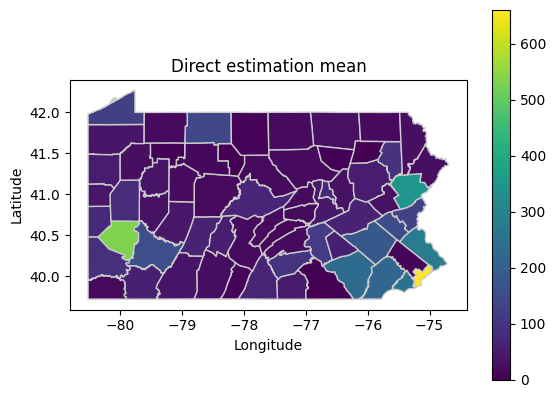

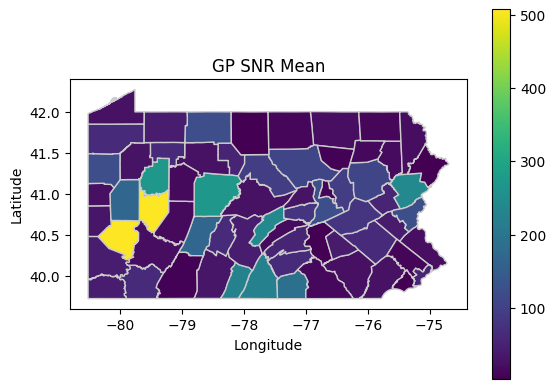

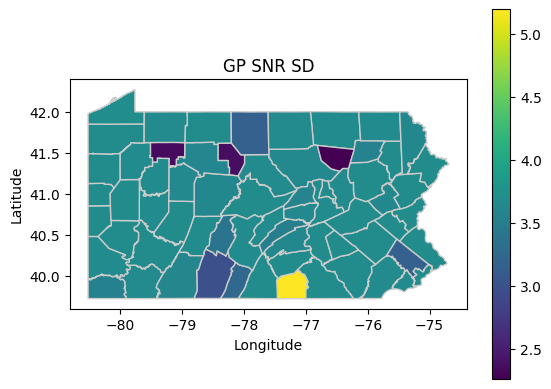

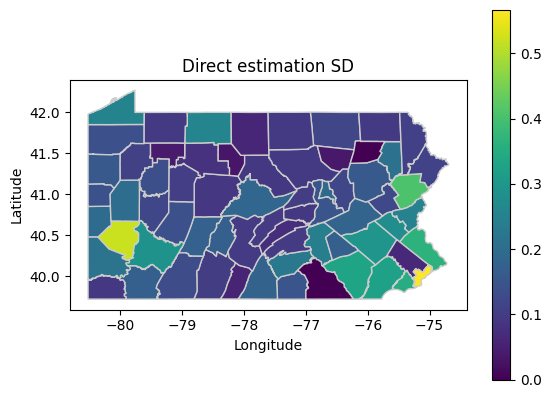

In [ ]:
plt.style.use('default') #was default #seaborn-whitegrid

#real
fitting = map_df.join(pd.DataFrame(df_average,columns=['real_avg']))
fitting.plot(column='real_avg', edgecolor='0.8',legend=True)
plt.title("Direct estimation mean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
####################################

#real stddev
df_std2 = df_std / np.sqrt(2000)
fitting = map_df.join(pd.DataFrame(df_std2,columns=['real_std']))
fitting.plot(column='real_std', edgecolor='0.8',legend=True)
plt.title("Direct estimation SD")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

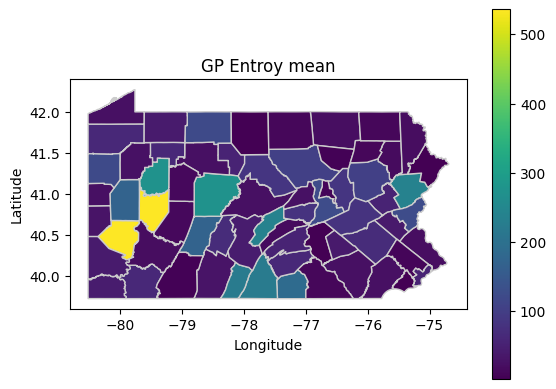

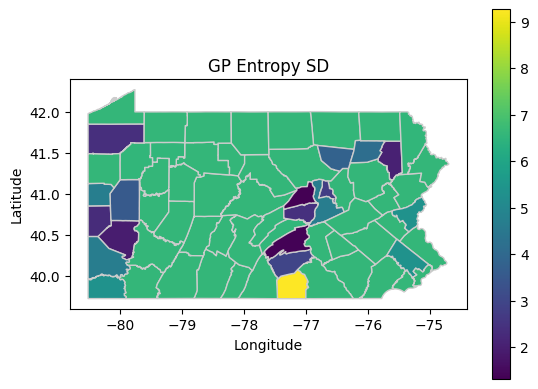

In [ ]:

####################################
#GPR mean
#gp_ei
ls_mean = gp_ei.posterior(train_X).mean.detach().numpy().flatten()
#print(gp_ucb.posterior(train_X).mean.detach().numpy().flatten())
fitting = map_df.join(pd.DataFrame(ls_mean,columns=['mean_gp']))
fitting.plot(column='mean_gp', edgecolor='0.8',legend=True)
plt.title("GP Entroy mean")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("\n")
#GPR stddev
ls_stddev = gp_ei.posterior(train_X).stddev.detach().numpy().flatten()
ls_ci = gp_ei.posterior(torch.Tensor(newls)).stddev.detach().numpy() #/ np.sqrt(np.array(count3)+iteration)
fitting = map_df.join(pd.DataFrame(ls_ci,columns=['ci_gp']))
fitting.plot(column='ci_gp', edgecolor='0.8',legend=True)
plt.title("GP Entropy SD")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()